<a href="https://colab.research.google.com/github/nkai842/Enron/blob/main/enron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Status report 5/3 

Accomplished:
-preprocessed message content and created different fields from content (receiver_name, sender_name, emails, message content, etc.)

-Created rudimentary social network graph for kenneth lay

-created graph displaying word frequency in corpus 

-showed top 10 email "senders" versus top 10 email "receivers" (ironically, the legal head of Enron sent the most emails in the network) 

Remaining work:
-Find TF-IDF scores

-Create more social network graphs 

-Track occurence of Enron glossary terms (?)

5/10 

Created cluster analysis of TFIDF matrix.

Plotted sentiment over time


Introduction:

The aim of this project is to investigate the Enron Corpus using social network anlalysis, cluster analysis, text mining and sentiment analysis to extract insights about fraudulent communications and individuals of interest.  I will use various techniques from DMML to clean the dataset and perform analyses.  Furthermore, matplotlib and seaborn will be used to create visualizations.  

In [ ]:
from google.colab import drive
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from bs4 import BeautifulSoup
import requests
import nltk
from textblob import TextBlob

#This part of networkx, for community detection, needs to be imported separately.
from networkx.algorithms import community 
from email.parser import Parser

from collections import Counter
import operator
from operator import itemgetter
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/emails.csv")
df


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...
...,...,...
517396,zufferli-j/sent_items/95.,Message-ID: <26807948.1075842029936.JavaMail.e...
517397,zufferli-j/sent_items/96.,Message-ID: <25835861.1075842029959.JavaMail.e...
517398,zufferli-j/sent_items/97.,Message-ID: <28979867.1075842029988.JavaMail.e...
517399,zufferli-j/sent_items/98.,Message-ID: <22052556.1075842030013.JavaMail.e...


In [ ]:

df['sender_email'] = df['message'].apply(lambda x: x.split("\n")[2].replace("From: ", ""))
df['receiver_email'] = df['message'].apply(lambda x: [i.replace('\n', '').strip() for i in x[x.find("To: ") + 4: x.find("\nSubject:")].split(",")])
df['sender_name'] = df['message'].str.findall(r'^X-From:.\s*(.*)\nX-To:', flags=re.MULTILINE).str[0]
df['receiver_name'] = df['message'].str.findall(r'^X-To:.\s*(.*)\nX-cc:', flags=re.MULTILINE).str[0]
df['subject'] = df['message'].str.findall(r'^Subject:.\s*(.*)\nMime-Version:', flags=re.MULTILINE).str[0]
df['date'] = df['message'].str.findall(r'^Date:.\s*(.*)\nFrom:', flags=re.MULTILINE).str[0]
print(df)

                             file  ...                                   date
0           allen-p/_sent_mail/1.  ...  Mon, 14 May 2001 16:39:00 -0700 (PDT)
1          allen-p/_sent_mail/10.  ...   Fri, 4 May 2001 13:51:00 -0700 (PDT)
2         allen-p/_sent_mail/100.  ...  Wed, 18 Oct 2000 03:00:00 -0700 (PDT)
3        allen-p/_sent_mail/1000.  ...  Mon, 23 Oct 2000 06:13:00 -0700 (PDT)
4        allen-p/_sent_mail/1001.  ...  Thu, 31 Aug 2000 05:07:00 -0700 (PDT)
...                           ...  ...                                    ...
517396  zufferli-j/sent_items/95.  ...  Wed, 28 Nov 2001 13:30:11 -0800 (PST)
517397  zufferli-j/sent_items/96.  ...  Wed, 28 Nov 2001 12:47:48 -0800 (PST)
517398  zufferli-j/sent_items/97.  ...  Wed, 28 Nov 2001 07:20:00 -0800 (PST)
517399  zufferli-j/sent_items/98.  ...  Tue, 27 Nov 2001 11:52:45 -0800 (PST)
517400  zufferli-j/sent_items/99.  ...  Mon, 26 Nov 2001 10:48:43 -0800 (PST)

[517401 rows x 8 columns]


In [ ]:
df['message_content'] = df['message'].apply(lambda x: Parser().parsestr(x).get_payload())
df['message_content'] = df['message_content'].str.strip()

In [ ]:
df['receiver_name'] = df['receiver_name'].str.replace('<[^>]+>', "", regex = True)
df['sender_name'] = df['sender_name'].str.replace('<[^>]+>', "", regex = True)
df['date'] = pd.to_datetime(df['date'])

1. Attributes are extracted from raw message using regex, split and Parser. Date is converted to datetime for ease of future sentiment analysis.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text

with open('stop_words_english.txt', encoding='utf8') as f:
    stop_list = [line.rstrip() for line in f]

content = df['message_content']

count_vect = CountVectorizer(lowercase=True, stop_words=stop_list, max_features=500, preprocessor = preprocess_text)
data_counts = count_vect.fit_transform(content)
print(data_counts.shape)
print(count_vect.get_feature_names())
data_counts.todense()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'al', 'couldn', 'daren', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'itse', 'mayn', 'mightn', 'mon', 'mustn', 'myse', 'needn', 'oughtn', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
data_tfidf = tfidf_transformer.fit_transform(data_counts)
tfidf = data_tfidf.todense()
tfidf

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.11543603, 0.        , ..., 0.        , 0.1141239 ,
         0.        ]])

2. TFIDF scores are calculated from field message_content.  Max features is set to 500.  Text is preprocessed to remove numbers.   Stop list from file system is used to remove common stop words.  

In [ ]:
x = count_vect.get_feature_names()
y = np.array(data_counts.todense()).sum(axis=0)

In [ ]:
counts = pd.DataFrame()
counts['term'] = x
counts['count'] = y
counts = counts.sort_values(by='count')
counts

,term,count
313,ou,18851
373,release,18895
15,approved,18900
186,greg,18950
421,standard,18970
...,...,...
429,subject,272136
343,power,272241
193,hou,567108
127,ect,1040261


3. Counts of terms are calculated. 

['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'orange', 'blue', 'orange', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'orange', 'blue']


Text(0.5, 1.0, 'Count of Terms Occuring >100,000 Enron Corpus')

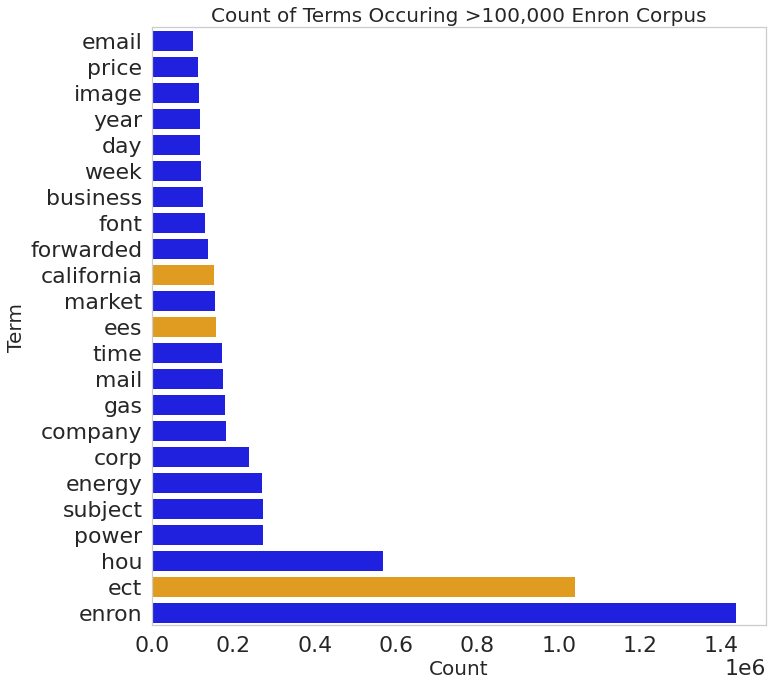

In [ ]:
import seaborn as sns

sns.set_theme()

above100000 = counts[counts['count'] > 100000]
above100000
# above100000.plot(y='count', x='term', kind='barh', legend=None)
# plt.xlabel('Count')
# plt.title('Terms used at least 100000 times in the corpus')
# plt.show()
plt.figure(figsize = (11,11))

labels = np.array(above100000.term)
values = np.array(above100000.count)

sns.set(font_scale = 2)
sns.set_style("whitegrid", {'axes.grid' : False})
clrs = ['orange' if label == "ees" or label == "ect" or label == 'california' else 'blue' for label in labels]
print(clrs)

sns.barplot(x='count', y='term', data=above100000, palette = clrs)
plt.xlabel("Count", fontsize = 20)
plt.ylabel("Term", fontsize = 20)
plt.title("Count of Terms Occuring >100,000 Enron Corpus", fontsize = 20)
      

4. Count of terms visualized in bart chart using log scale.  Terms of interest colored orange.  

In [ ]:

from_list = []
to_list = []

for index, row in df.iterrows():
  for i in row['receiver_email']:
    if i == '':
      pass
    else:
      to_list.append(i.strip())
  from_list.append(row['sender_email'])



In [ ]:
top10_to = Counter(to_list).most_common(10)
top10_from = Counter(from_list).most_common(10)
print("Sender List:", top10_from)
print("Recipient List:", top10_to)

Sender List: [('kay.mann@enron.com', 16735), ('vince.kaminski@enron.com', 14368), ('jeff.dasovich@enron.com', 11411), ('pete.davis@enron.com', 9149), ('chris.germany@enron.com', 8801), ('sara.shackleton@enron.com', 8777), ('enron.announcements@enron.com', 8587), ('tana.jones@enron.com', 8490), ('steven.kean@enron.com', 6759), ('kate.symes@enron.com', 5438)]
Recipient List: [('richard.shapiro@enron.com', 15149), ('jeff.dasovich@enron.com', 14207), ('tana.jones@enron.com', 12828), ('steven.kean@enron.com', 12754), ('sara.shackleton@enron.com', 11433), ('james.steffes@enron.com', 10347), ('mark.taylor@enron.com', 9787), ('pete.davis@enron.com', 9281), ('susan.mara@enron.com', 9064), ('paul.kaufman@enron.com', 8522)]


5. Top 10 senders and recipients calculated above using for loop and Counter class.  Kay Mann and Richard Shapiro are noteable for their roles in the legal and government affairs departments, respectively.  Furthermore, Richard Shapiro served as the chief lobbyist for Enron and was in regular communication with the Bush administration.  

In [ ]:
skilling_to = []
skilling_from = []

for index, row in df.iterrows():
  if "jeff.skilling@enron.com" in row['receiver_email']:
    for i in row['sender_email']:
      skilling_to.append(i)
  if "jeff.skilling@enron.com" in row['sender_email']:
    for i in row['receiver_email']:
      skilling_from.append(i)

print(Counter(skilling_to).most_common(10))
print(Counter(skilling_from).most_common(10))
## Sheri sara was skilling's administrative assistant, been with skilling since his days as a McKinsey & Company consultant

[('lisa.connolly@enron.com', 120), ('vince.kaminski@enron.com', 32), ('david.delainey@enron.com', 26), ('jeffrey.shankman@enron.com', 25), ('steven.kean@enron.com', 23), ('sally.beck@enron.com', 20), ('karen.denne@enron.com', 17), ('fparra@swbanktx.com', 17), ('nicki.daw@enron.com', 16), ('kay.chapman@enron.com', 15)]
[('sherri.sera@enron.com', 16), (' hgutier@enron.com', 15), (' bvotaw@enron.com', 15), (' rick.buy@enron.com', 12), (' \trobert.hayes@enron.com', 12), (' joe.kishkill@enron.com', 12), (' brian.stanley@enron.com', 12), (' \trebecca.carter@enron.com', 11), (' \tcedric.burgher@enron.com', 9), (' rick.craig@enron.com', 9)]


6. Top 10 senders to and recipients of Jeff Skilling's emails calculated similarly to above.

In [ ]:
names = set()

for index, row in df.iterrows():
  for i in row['receiver_email']:
    if i != 'klay@enron.com':
      names.add(i)
  names.add(row['sender_email'])
print(len(names))

80161


In [ ]:
edges = []
for index, row in df.iterrows():
  source = row['sender_email']
  for i in row['receiver_email']:
    if i == "klay@enron.com":
      edges.append((source, 'kenneth.lay@enron.com')
    else:
      edges.append((source, i))

In [ ]:
G = nx.Graph()
G.add_nodes_from(names)
G.add_edges_from(edges)
print(nx.info(G))



Name: 
Type: Graph
Number of nodes: 80162
Number of edges: 290144
Average degree:   7.2389


7. Node names and edges added in for loop for overall network.  Network information printed for network (Note: network includes ALL emails, senders and receivers).

In [ ]:
fraud_terms = ['Cover up', 'Write off', 'Illegal', 'Failed investment', 'Nobody will find out', 'Gray area', 'They owe it to me', 'Do not volunteer information', 'Not ethical', 'Off the books', 
               'affair', 'FERC', 'devastating', 'investigation', 'disclosure', 'bonus']

fraud = pd.DataFrame();


for index, row in df.iterrows():
  if 'enron.com' in row['sender_email']:
    for i in fraud_terms:
      if i in row['message_content']:
        fraud = fraud.append(row);

8. New dataframe for storing fraudulent emails created.  Emails are checked for presence of terms and if found, added to fraud dataframe.

In [ ]:
names = set()

for index, row in fraud.iterrows():
  for i in row['receiver_email']:
    if i != 'klay@enron.com':
      names.add(i)

  names.add(row['sender_email'])
print(len(names))

5970


In [ ]:
edges = []
for index, row in fraud.iterrows():
  source = row['sender_email']
  for i in row['receiver_email']:
    if i == "klay@enron.com":
      edges.append((source, 'kenneth.lay@enron.com'))
    else:
      edges.append((source, i))

Sorted degree: [('jeff.dasovich@enron.com', 464), ('karen.denne@enron.com', 303), ('alan.comnes@enron.com', 297), ('christi.nicolay@enron.com', 287), ('maureen.mcvicker@enron.com', 277), ('susan.mara@enron.com', 266), ('sarah.novosel@enron.com', 260), ('ginger.dernehl@enron.com', 260), ('richard.shapiro@enron.com', 259), ('janel.guerrero@enron.com', 241)]
Sorted eigenvector [('richard.shapiro@enron.com', 0.19082679197576913), ('alan.comnes@enron.com', 0.1891911058911881), ('jeff.dasovich@enron.com', 0.18629546286498383), ('sarah.novosel@enron.com', 0.1830184921260879), ('ginger.dernehl@enron.com', 0.18289604973618329), ('susan.mara@enron.com', 0.16960720777647315), ('janel.guerrero@enron.com', 0.15533379237331302), ('maureen.mcvicker@enron.com', 0.1517857429029684), ('bernadette.hawkins@enron.com', 0.15159470286697596), ('james.steffes@enron.com', 0.14895175299809854)]


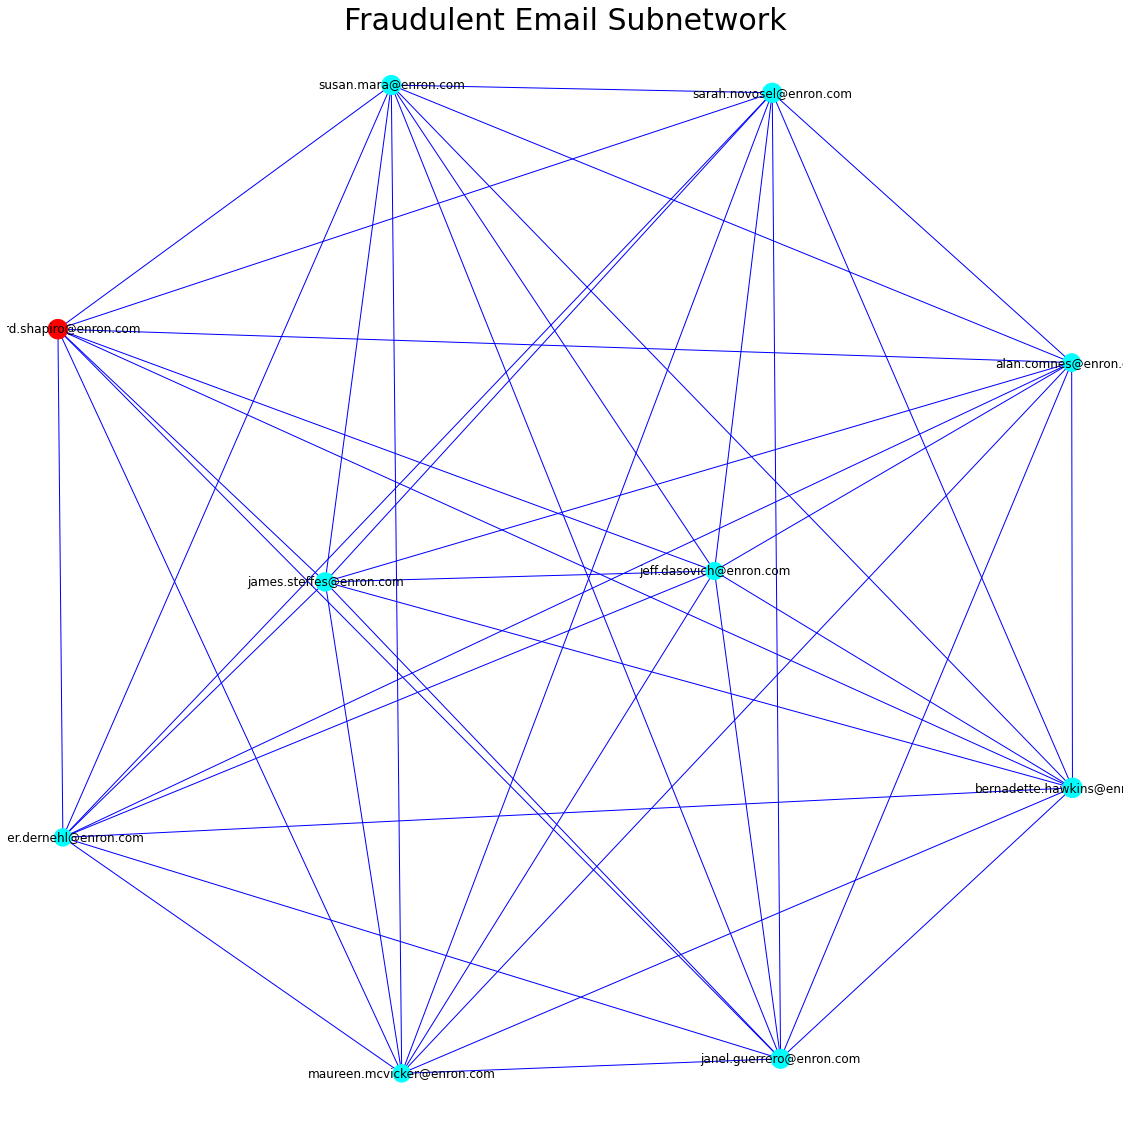

In [ ]:
import itertools
from statistics import mean

G = nx.Graph()
G.add_nodes_from(names)
G.add_edges_from(edges)

degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')

eigenvector_dict = nx.eigenvector_centrality(G) 
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')

sorted_eigen = sorted(eigenvector_dict.items(), key=itemgetter(1), reverse=True)[:10]

sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)[:10]

sorted_degree_names = [n[0] for n in sorted_degree]
sorted_eigen_names =  [n[0] for n in sorted_eigen]
sorted_eigen_value = [n[1] for n in sorted_eigen]
print("Sorted degree:", sorted_degree)
print("Sorted eigenvector", sorted_eigen)
G1 = G.subgraph(sorted_eigen_names)

node_sizes = [v*2000 for v in sorted_eigen_value]
print
pos = nx.spring_layout(G1, k=2.2)

plt.figure(figsize=(20,20))
plt.axis('off')
color_map = []

for node in G1:
  if node != 'richard.shapiro@enron.com':
    color_map.append('#00FFFF')
  else:
    color_map.append('red')

 
nx.draw_networkx(G1, pos, with_labels=True, width=1, edge_color = '#0000FF', node_color = color_map, node_size = node_sizes)
plt.title("Fraudulent Email Subnetwork", fontsize = 30)
plt.show()

9. Top 10 degree and eigenvector nodes printed for fraud subnetwork.  SNA subgraph created for fraud dataframe.  Top 10 nodes by eigenvector centrality plotted.  Richard Shapiro highlighted red to emphasize importance in network.  Node sizes calculated using eigenvector value.    

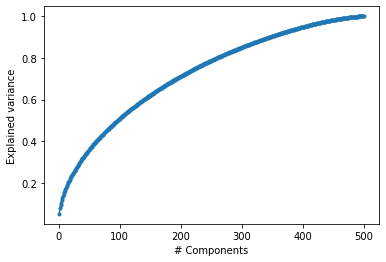

In [ ]:
from sklearn.decomposition import PCA

number_of_rows = tfidf.shape[0]

random_indices = np.random.choice(number_of_rows, size=100000, replace=False)


X = tfidf[random_indices]

tfidf_pca = PCA(n_components=500).fit(X)

cs = np.cumsum(tfidf_pca.explained_variance_ratio_)
plt.plot(np.arange(1, 501), cs, '.-')
plt.xlabel('# Components')
plt.ylabel('Explained variance');


# tfidf_pca


# tfidf2 = tfidf_pca.transform(X)


Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters


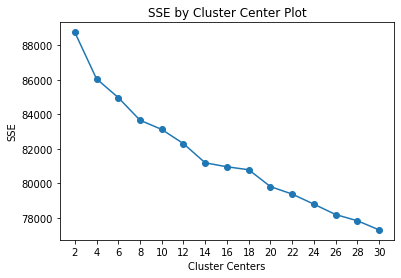

In [ ]:
from sklearn.cluster import MiniBatchKMeans

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(X, 30)

10. PCA dimensionality reduction and cluster analysis run on TFIDF scores.  PCA dimensionality reduction yields no results (each component contributes equally to variance).  Cluster analysis shows many clusters in the overall data, 4 clusters chosen for convenience of labeling.  Cluster population created from 100,000 random emails from the overall dataset. 

In [ ]:
from sklearn.cluster import KMeans



k = 4
clt = KMeans(n_clusters=k)


clt.fit(X)



cluster_labels = clt.predict(X)

In [ ]:
def get_top_keywords(data, clusters, labels, n_terms):
    df1 = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df1.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))

get_top_keywords(data_tfidf[random_indices], cluster_labels ,count_vect.get_feature_names(), 30)


Cluster 0
company,free,business,houston,office,agreement,october,november,file,group,contact,list,mark,report,work,send,market,jeff,john,doc,deal,week,today,day,questions,meeting,power,gas,energy,enron

Cluster 1
meeting,contact,contract,request,review,john,energy,ees,employees,mark,eb,street,legal,company,hou,texas,doc,smith,phone,intended,jeff,agreement,north,america,mann,houston,ect,kay,corp,enron

Cluster 2
version,john,davis,update,general,transaction,type,number,deal,ees,individual,price,process,firm,data,error,generation,energy,load,required,table,details,file,california,portland,start,schedule,hour,final,schedules

Cluster 3
taylor,eric,scott,america,agreement,north,shackleton,meeting,communications,mike,deals,gas,jones,sara,david,enron_development,tana,chris,john,pdx,mark,kaminski,ees,lon,deal,vince,corp,enron,hou,ect


11. Top 30 terms for each cluster printed above.  Cluster labels in order: Meetings, Legal/Govt. Affairs, Enron Energy Services, Enron Capital and Trading.  For future analysis I would examine emails under the  Legal/Govt. Affairs and Enron capital and trading clusters. 

In [ ]:

def remove_stopwords(message):
  for i in stop_list:
    if i in message:
      message.replace(i, "")
  
  return message

df['senti_score'] = df['message_content'].apply(lambda x: TextBlob(remove_stopwords(x.lower())).sentiment)
df['senti_score']



0                                         (0.0, 0.0)
1           (0.18181818181818182, 0.603030303030303)
2                                        (1.0, 0.95)
3                                         (0.0, 0.0)
4                                         (0.0, 0.0)
                             ...                    
517396                                    (0.0, 0.0)
517397                                   (0.05, 0.7)
517398     (0.1527777777777778, 0.42777777777777776)
517399                                   (-0.8, 0.9)
517400    (0.04756704980842913, 0.49863984674329503)
Name: senti_score, Length: 517401, dtype: object

12. Sentiment analysis conducted on message_content field.  Same list of stop words used in TFIDF calculation used to preprocess text.  

In [ ]:
df['date_formatted'] = df['date'].apply(lambda x: pd.to_datetime(x.strftime('%y-%m-%d'), format = "%y-%m-%d"))

In [ ]:
df['polarity'] = df['senti_score'].apply(lambda x: x[0])


                polarity
date_formatted          
1999-01-04      0.034749
1999-01-05      0.335000
1999-01-06      0.060745
1999-01-07      0.212037
1999-01-08      0.057171
...                  ...
2002-05-27      0.185902
2002-05-28      0.014885
2002-05-29      0.020464
2002-05-30      0.017430
2002-05-31      0.010010

[1158 rows x 1 columns]


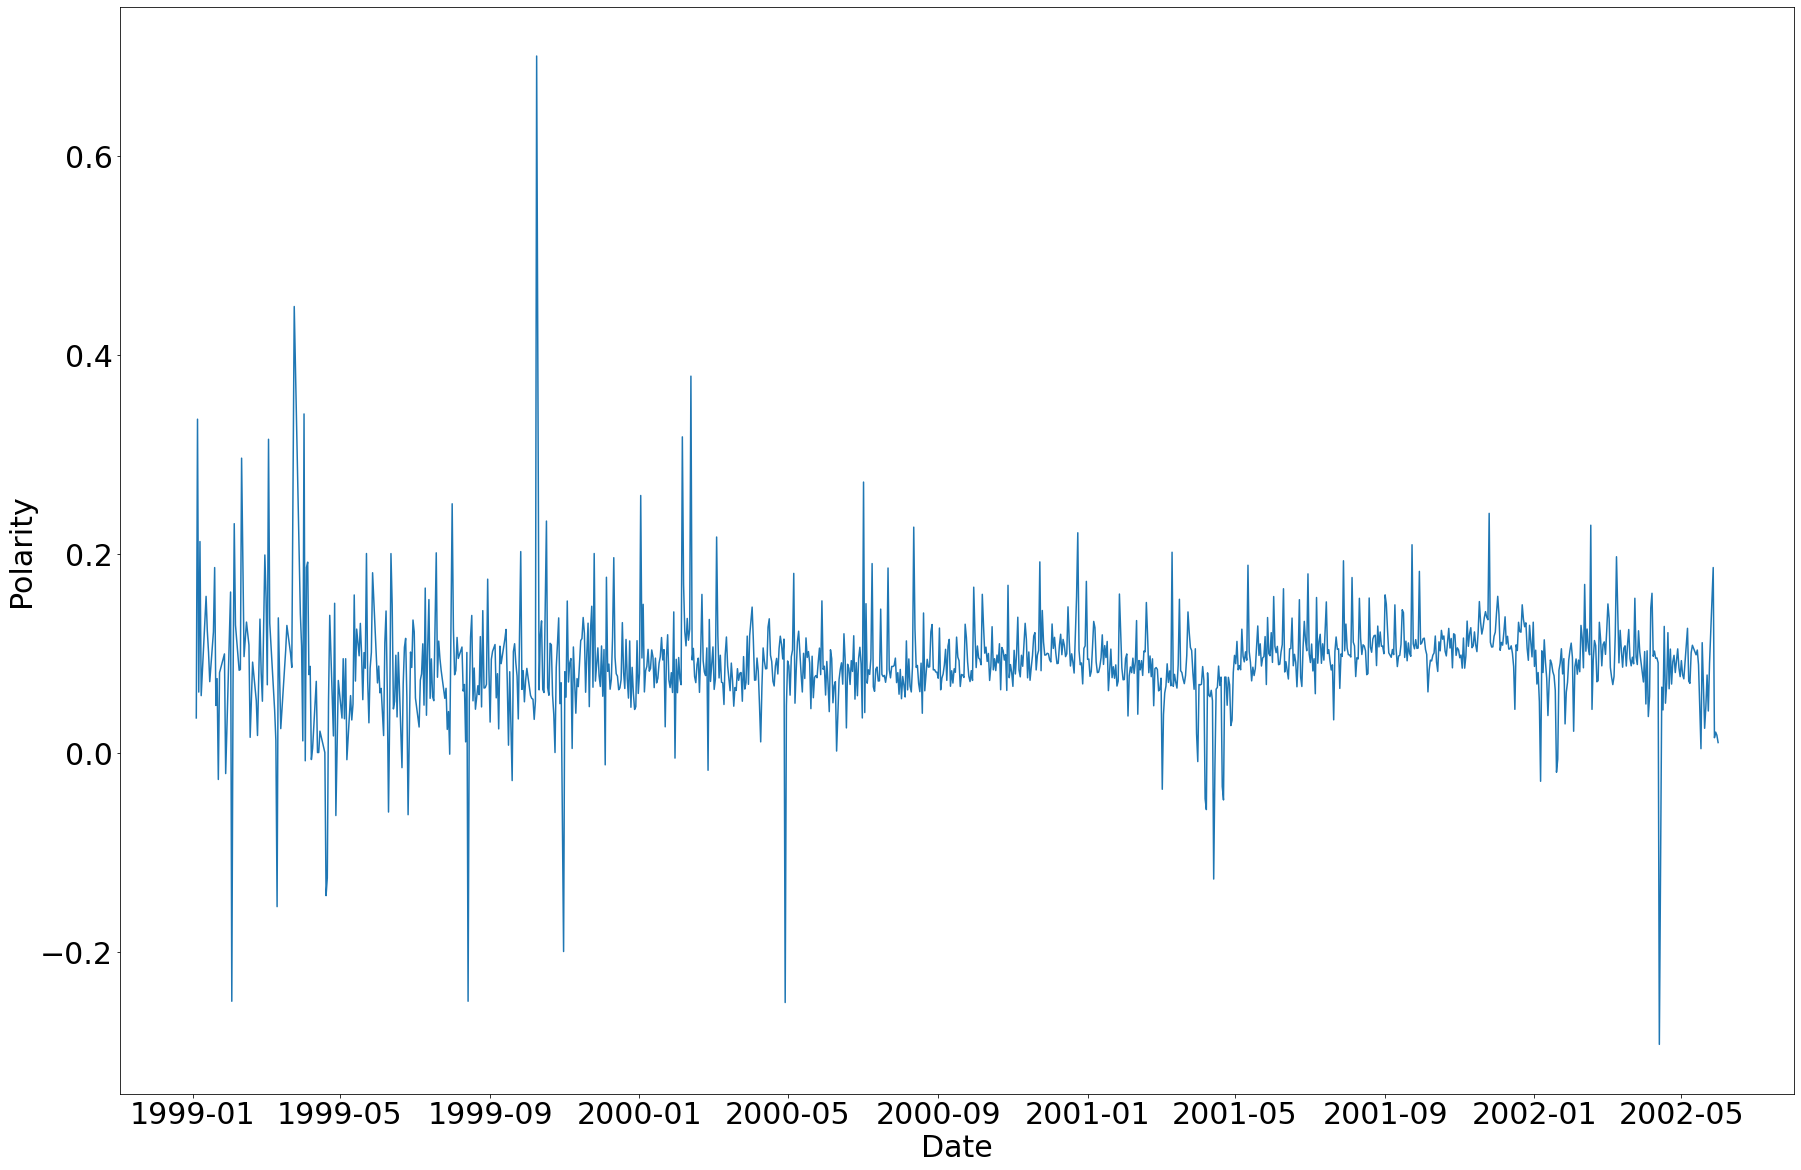

In [ ]:
plt.figure(figsize = (30,20))

x = df[['sender_email','polarity', 'date_formatted', 'message_content', 'message']].sort_values(by = 'date_formatted')
filterX = x[x['date_formatted'] > '1999-01-01']
df1 = filterX[filterX['date_formatted'] < "2002-06-01"]
dfdate = df1.groupby('date_formatted').mean().sort_values(by = "date_formatted")
print(dfdate)
plt.plot(dfdate)
plt.xlabel("Date", fontsize = 30, c = '#000000')
plt.xticks(fontsize = 30, c = '#000000')
plt.ylabel("Polarity", fontsize = 30, c = '#000000')
plt.yticks(fontsize = 30, c = '#000000')
plt.show()

# for index, row in df1[(df1.date_formatted >= "2000-05-01") & (df1.date_formatted <= "2000-05-30")].iterrows():
#   print(row['message_content'])

13. Date formatted into %y-%m-%d.  Polarity extracted from textblob sentiment tuple.  Dates filtered for relevant dates.  Date along with mean polarity plotted above.  Chart annotated with outside program to show timeline.

Conclusions: 

Overall, the majority of my efforts were realized through trial and effort.  There were many instances of experimentation by tweaking and changing inputs to yield interesting results.  Given the inclusion of cluster analysis and sentiment analysis my code warrants a high grade.  One issue I identified that still perplexes me is with dates.  Some emails have dates that are too high or low to make sense given the range of years the emails originate from.  My theory is that these emails are related to calendar or other email content aside from mail.  I would have used the Parser class to more effect if I learned of it earlier to parse emails rather than rely on regex/split.  Furthermore, with greater memory I could have run cluster analysis on the entire dataset rather than 100,000 entries.  